We will begin with a few imports that we would need while implementing Decision Tree

In [0]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pydotplus 

from IPython.display import Image  
from collections import defaultdict
from sklearn.dummy import DummyClassifier
from sklearn import svm, tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline


#Collecting Data

The dataset can be found at the UCI Machine Learning Data Repository http://archive.ics.uci.edu/ml
The dataset contains information on loans obtained from a credit agency in Germany. 

This dataset contains 1,000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes on credit risk by a German bank. Each person is classified as good or bad credit risks according to the set of attributes.

#Exploring and preparing the data

In [85]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [86]:
df = 'gdrive/My Drive/ALY_6020/credit.csv'
data = pd.read_csv(df)
data.head (5)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,residence_history,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,4,real estate,67,none,own,2,1,1,yes,yes,skilled employee
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,2,real estate,22,none,own,1,2,1,none,yes,skilled employee
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,3,real estate,49,none,own,1,1,2,none,yes,unskilled resident
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,4,building society savings,45,none,for free,1,1,2,none,yes,skilled employee
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,4,unknown/none,53,none,for free,2,2,2,none,yes,skilled employee


In [87]:
data.describe()

,months_loan_duration,amount,installment_rate,residence_history,age,existing_credits,default,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.300000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.458487,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [88]:
#information about data variable types
data.info

<bound method DataFrame.info of     checking_balance  ...                      job
0             < 0 DM  ...         skilled employee
1         1 - 200 DM  ...         skilled employee
2            unknown  ...       unskilled resident
3             < 0 DM  ...         skilled employee
4             < 0 DM  ...         skilled employee
..               ...  ...                      ...
995          unknown  ...       unskilled resident
996           < 0 DM  ...  mangement self-employed
997          unknown  ...         skilled employee
998           < 0 DM  ...         skilled employee
999       1 - 200 DM  ...         skilled employee

[1000 rows x 21 columns]>

In [0]:
#create quickaccess list with categorical variables labels
catvars = ['checking_balance', 'credit_history', 'purpose', 'savings_balance',
           'personal_status', 'other_debtors', 'property', 'installment_plan', 'housing', 'job', 
           'telephone', 'foreign_worker']
#create quickaccess list with numerical variables labels
numvars = ['amount', 'months_loan_duration', 'installment_rate', 'residence_history', 'age', 
           'existing_credits', 'dependents']

#Processing text data for analysis

##Data Cleaning

**Missing Value** 


In [90]:
data.apply(lambda x: sum(x.isnull()))

checking_balance        0
months_loan_duration    0
credit_history          0
purpose                 0
amount                  0
savings_balance         0
employment_length       0
installment_rate        0
personal_status         0
other_debtors           0
residence_history       0
property                0
age                     0
installment_plan        0
housing                 0
existing_credits        0
default                 0
dependents              0
telephone               0
foreign_worker          0
job                     0
dtype: int64

No missing value

##Visualization

In [0]:
# Visualize tree and save as .pdf
# Only works for dataframes, not for numpy arrays
def visualize_tree(clf,X_train,y_train):
    dot_data = export_graphviz(clf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("dectreeclf.pdf") 
     
        
    dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=[str(x) for x in X_train.columns.tolist()], # feature names from X_train column names
                         class_names=[str(x) for x in clf.classes_],
                         filled=True, rounded=True,  
                         special_characters=True,
                         leaves_parallel=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    Image(graph.create_png()) 
    return

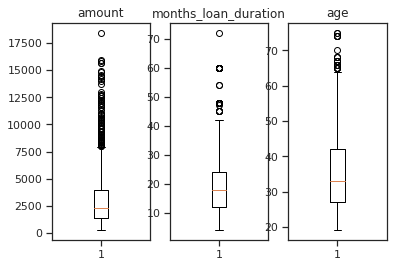

In [92]:
# Boxplots for continuous attributes
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].boxplot(data['amount'])
axes[0].set_title('amount')
axes[1].boxplot(data['months_loan_duration'])
axes[1].set_title('months_loan_duration')
axes[2].boxplot(data['age'])
axes[2].set_title('age')

fig.savefig("boxplots.png")

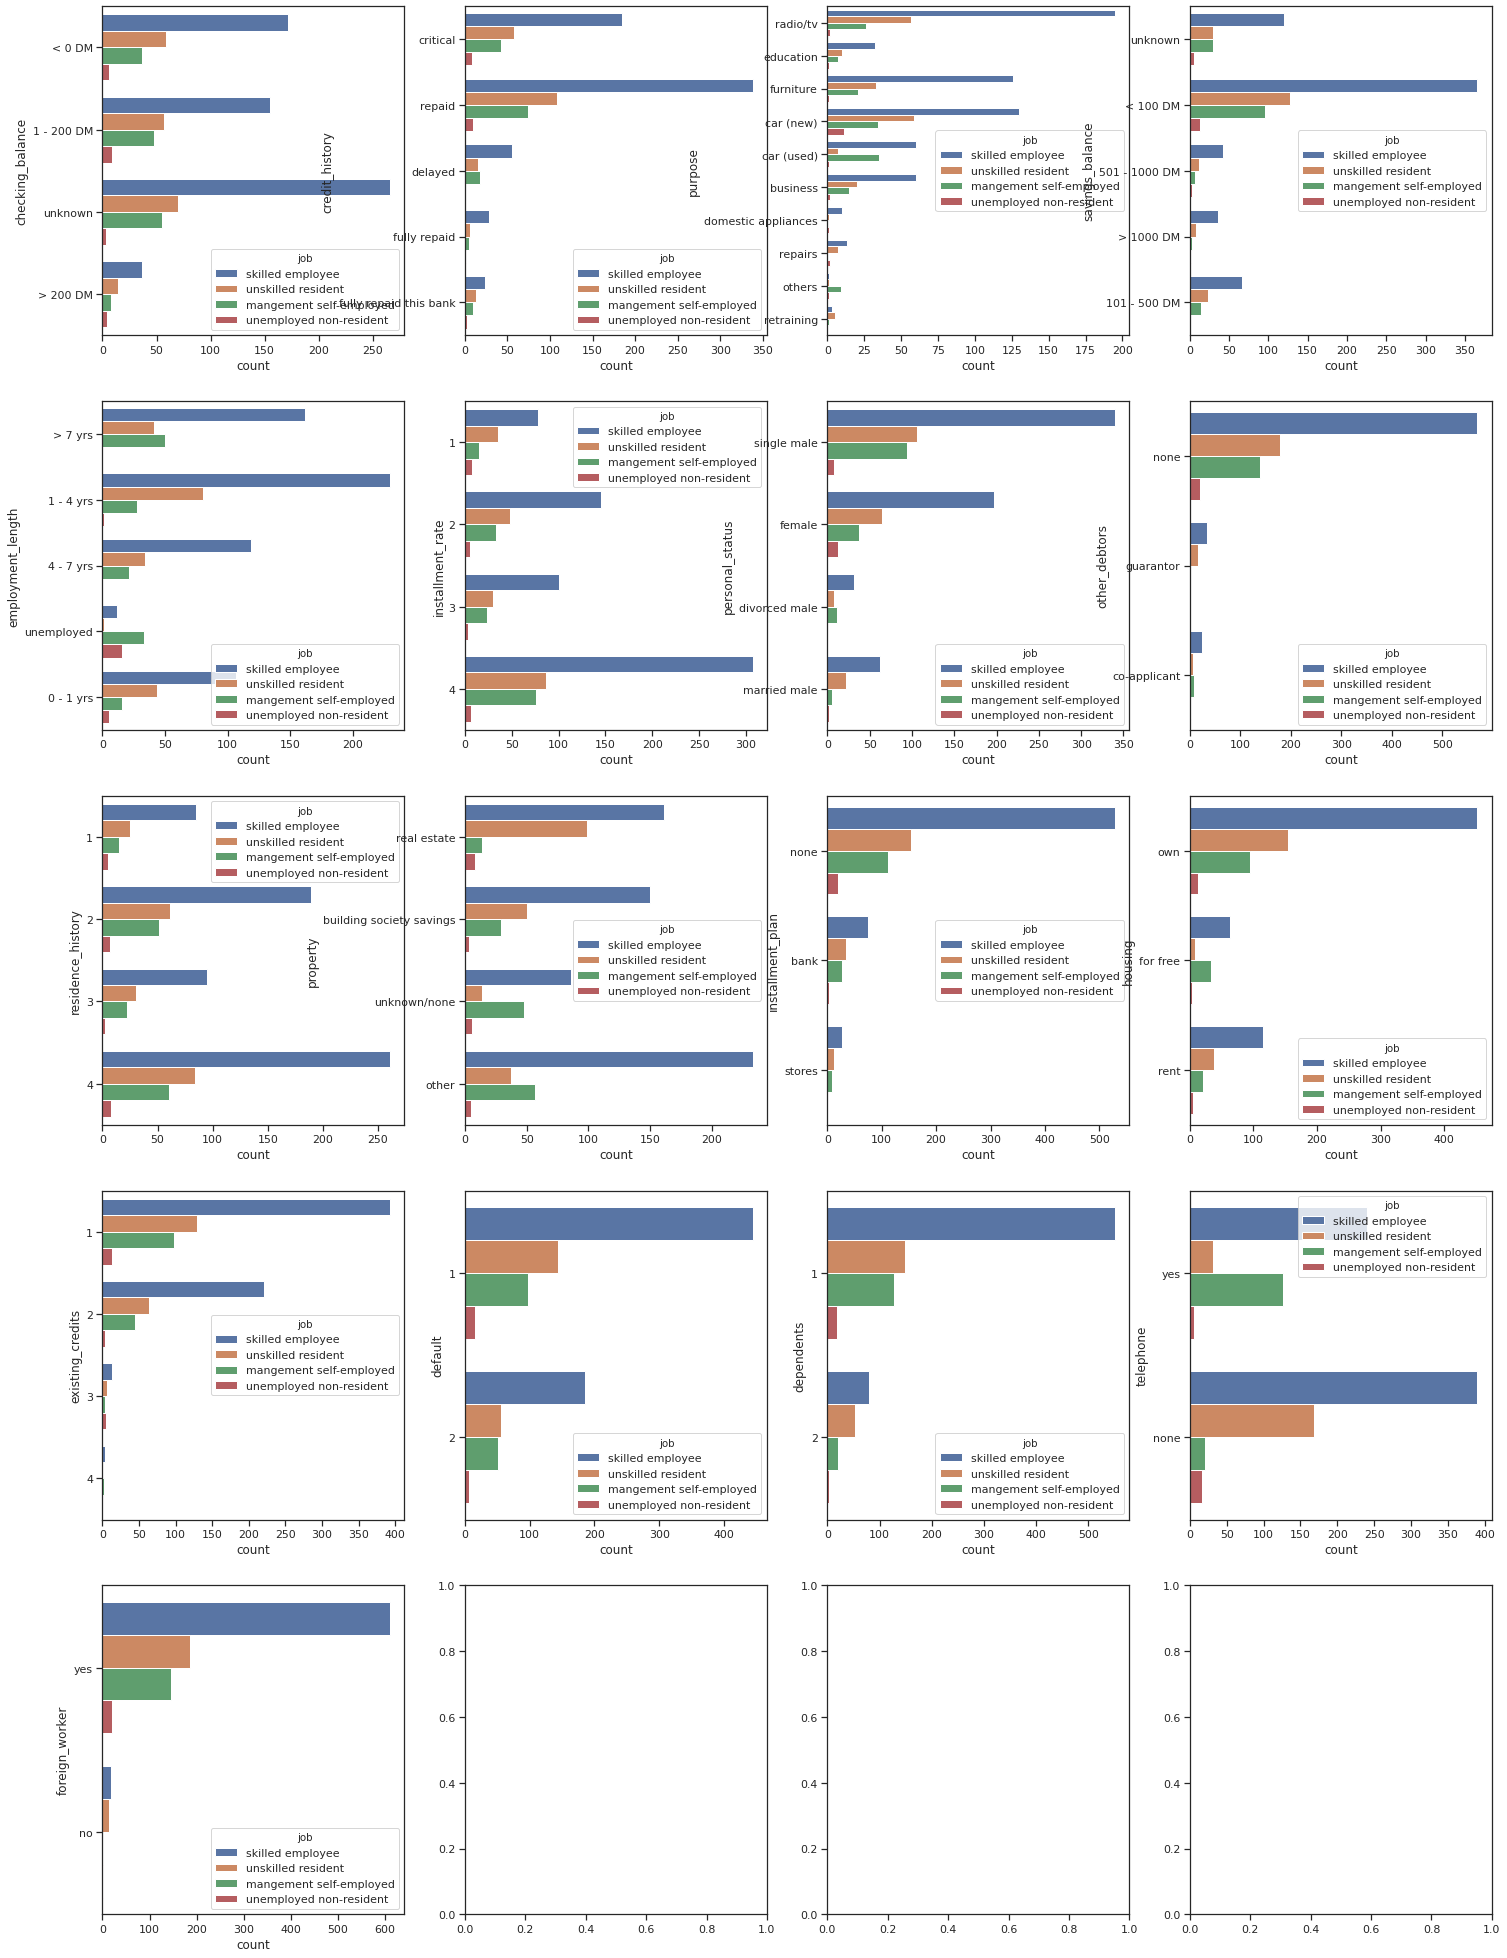

In [93]:
# Histograms for non-continuous attributes
f, axes = plt.subplots(5, 4,figsize=(8.3*3,11.7*3))
x=0
y=0
for column in data.drop(['job','amount','months_loan_duration','age'], axis=1):
    sns.countplot(y=column, hue="job", data=data.drop(['amount','months_loan_duration','age'],axis=1), ax=axes[x,y])
    y+=1
    if y>3:
        x+=1
        y=0
    if x>4:
        break
f.savefig("histograms5.png")

#Data Transformation

##Numerical features

In [94]:
# Numerical features range of values
for x in range(len(numvars)):
    print(numvars[x],": ", data[numvars[x]].min()," - ",data[numvars[x]].max())

amount :  250  -  18424
months_loan_duration :  4  -  72
installment_rate :  1  -  4
residence_history :  1  -  4
age :  19  -  75
existing_credits :  1  -  4
dependents :  1  -  2


In [95]:
# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['dependents'], axis=1)))
# MinMax Rescaling to [0,1]
numdata_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[numvars].drop(['dependents'], axis=1)))
print("success")

success


##Encoding categorical features

In [96]:
# Labelencoding to transform categorical to numerical
# Enables better Visualization than one hot encoding
d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

checking_balance :  ['< 0 DM' '1 - 200 DM' 'unknown' '> 200 DM']
checking_balance :  [1 0 3 2]
credit_history :  ['critical' 'repaid' 'delayed' 'fully repaid' 'fully repaid this bank']
credit_history :  [0 4 1 2 3]
purpose :  ['radio/tv' 'education' 'furniture' 'car (new)' 'car (used)' 'business'
 'domestic appliances' 'repairs' 'others' 'retraining']
purpose :  [7 4 5 1 2 0 3 8 6 9]
savings_balance :  ['unknown' '< 100 DM' '501 - 1000 DM' '> 1000 DM' '101 - 500 DM']
savings_balance :  [4 2 1 3 0]
personal_status :  ['single male' 'female' 'divorced male' 'married male']
personal_status :  [3 1 0 2]
other_debtors :  ['none' 'guarantor' 'co-applicant']
other_debtors :  [2 1 0]
property :  ['real estate' 'building society savings' 'unknown/none' 'other']
property :  [2 0 3 1]
installment_plan :  ['none' 'bank' 'stores']
installment_plan :  [1 0 2]
housing :  ['own' 'for free' 'rent']
housing :  [1 0 2]
job :  ['skilled employee' 'unskilled resident' 'mangement self-employed'
 'unemployed

In [0]:
# One hot encoding
#create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

###Concat transformed datasets

In [98]:
# append the dummy variable of the initial numerical variables numvars
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)
data_std = pd.concat([numdata_std, data['dependents'], dummyvars], axis = 1)
data_minmax = pd.concat([numdata_minmax, data['dependents'], dummyvars], axis = 1)
print(data_clean.shape)
print(data_std.shape)
print(data_minmax.shape)

(1000, 56)
(1000, 56)
(1000, 56)


#Split the data into train and test


In [0]:
# Unscaled, unnormalized data
X_clean = data_clean.drop('dependents', axis=1)
y_clean = data_clean['dependents']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.3333, random_state=1)

# Standardized data
X_std = data_std.drop('dependents', axis=1)
y_std = data_std['dependents']
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std,y_std,test_size=0.3333, random_state=1)

# Rescaled data
X_minmax = data_minmax.drop('dependents', axis=1)
y_minmax = data_minmax['dependents']
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax,y_minmax,test_size=0.3333, random_state=1)

In [100]:
# Oversampling
# http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py

# Apply SMOTE
sm = SMOTE(ratio='auto')
X_train_clean_res, y_train_clean_res = sm.fit_sample(X_train_clean, y_train_clean)
X_train_std_res, y_train_std_res = sm.fit_sample(X_train_std, y_train_std)
X_train_minmax_res, y_train_minmax_res = sm.fit_sample(X_train_minmax, y_train_minmax)

# Print number of 'good' credits and 'bad credits, should be fairly balanced now
print("Before/After clean")
unique, counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_clean_res, return_counts=True)
print(dict(zip(unique, counts)))
print("Before/After std")
unique, counts = np.unique(y_train_std, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_std_res, return_counts=True)
print(dict(zip(unique, counts)))
print("Before/After minmax")
unique, counts = np.unique(y_train_minmax, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_minmax_res, return_counts=True)
print(dict(zip(unique, counts)))

Before/After clean
{1: 574, 2: 92}
{1: 574, 2: 574}
Before/After std
{1: 574, 2: 92}
{1: 574, 2: 574}
Before/After minmax
{1: 574, 2: 92}
{1: 574, 2: 574}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Fit a decision tree model to the data.


In [0]:
# fit, train and cross validate Decision Tree with training and test data 
def dectreeclf(X_train, y_train,X_test, y_test):
    print("DecisionTreeClassifier")
    dec_tree = tree.DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=5).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = dec_tree.predict(X_test)

    # Export visualization as file
    #visualize_tree(dec_tree,X_train,y_train)
    
    # Get Cross Validation and Confusion matrix
    get_eval(dec_tree, X_train, y_train,y_test,y_pred)
    return

# Visualize tree and save as .pdf
# Only works for dataframes, not for numpy arrays
def visualize_tree(clf,X_train,y_train):
    dot_data = export_graphviz(clf, out_file=None) 
    graph = pydotplus.graph_from_dot_data(dot_data) 
    graph.write_pdf("dectreeclf.pdf") 
     
        
    dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=[str(x) for x in X_train.columns.tolist()], # feature names from X_train column names
                         class_names=[str(x) for x in clf.classes_],
                         filled=True, rounded=True,  
                         special_characters=True,
                         leaves_parallel=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    Image(graph.create_png()) 
    return

In [102]:
# Dummy Classifier
print("DummyClassifier")
dclf = DummyClassifier(strategy='stratified').fit(X_train_clean, y_train_clean)

# Predict target variables y for test data
y_pred = dclf.predict(X_test_clean)

# Get Cross Validation and Confusion matrix
get_eval(dclf, X_train_clean, y_train_clean,y_test_clean,y_pred)

DummyClassifier
Cross Validation Accuracy: 0.76 (+/- 0.03)
Cross Validation Precision: 0.86 (+/- 0.01)
Cross Validation roc_auc: 0.49 (+/- 0.06)
[[232  39]
 [ 57   6]]


In [104]:
# Decision tree
# Train, test and evaluate the classifiers with different preprocessed data
print("clean resampled")
dectreeclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

clean resampled
DecisionTreeClassifier
Cross Validation Accuracy: 0.85 (+/- 0.09)
Cross Validation Precision: 0.88 (+/- 0.13)
Cross Validation roc_auc: 0.90 (+/- 0.10)
[[232  39]
 [ 42  21]]
